In [1]:
import sys
import os
# Manually set the project root directory (adjust if needed)
project_root = os.path.abspath("..")  # Moves up one level to project root

# Add the project directory to sys.path
sys.path.append(project_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import pickle
import time
import glob
from tqdm.autonotebook import tqdm
from EarlyStopping import EarlyStopping  # Ensure EarlyStopping is available
from Training.PyTorchModular import train_model, loss_curve
from sklearn.metrics import mean_squared_error
# Now import the RNN model
from Models.RNN import RNNModel

C:\Users\sandr\AppData\Local\Temp\ipykernel_22380\3226215619.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import shutil

# **Ensure Model Save Path Exists**
model_save_path = "models/RNN"
os.makedirs(model_save_path, exist_ok=True)  # Create if not exists

# **Delete all existing files in the RNN model directory**
for file in os.listdir(model_save_path):
    file_path = os.path.join(model_save_path, file)
    if os.path.isfile(file_path) or os.path.islink(file_path):
        os.unlink(file_path)  # Remove files and symlinks



Columns in dataset: Index(['observation_date', 'fred_PCEPI', 'fred_AAAFFM', 'fred_AAAFFM_PC1',
       'fred_AHETPI', 'fred_AHETPI_LOG', 'fred_APU000072610_PCA',
       'fred_APU000074714', 'fred_APU000074714_CCA', 'fred_APU000074714_CCH',
       ...
       'CMO-Historical-Data-Monthly_Food',
       'CMO-Historical-Data-Monthly_Oils_and_meals',
       'CMO-Historical-Data-Monthly_Grains',
       'CMO-Historical-Data-Monthly_Other_foods',
       'CMO-Historical-Data-Monthly_Raw_materials',
       'CMO-Historical-Data-Monthly_Other_raw_materials',
       'CMO-Historical-Data-Monthly_Fertilizers',
       'CMO-Historical-Data-Monthly_Metals_minerals',
       'CMO-Historical-Data-Monthly_Base metals',
       'CMO-Historical-Data-Monthly_Precious_metals'],
      dtype='object', length=356)
Using 'observation_date' as Date column.


  0%|          | 0/50 [00:00<?, ?it/s]

	Batch: 0
Train Loss epoch 0: 0.05307284825377994
Valid Loss epoch 0: 0.22421950101852417
	Batch: 0
Train Loss epoch 1: 0.03281052741739485
Valid Loss epoch 1: 0.029507495048973296
	Batch: 0
Train Loss epoch 2: 0.006002033724346095
Valid Loss epoch 2: 0.005513991850117843
	Batch: 0
Train Loss epoch 3: 0.0017141338321380317
Valid Loss epoch 3: 0.006079652864072058
	Batch: 0
Train Loss epoch 4: 0.0007575196383792596
Valid Loss epoch 4: 0.0006802979834093195
	Batch: 0
Train Loss epoch 5: 0.0002629142755823624
Valid Loss epoch 5: 0.001868067645571298
	Batch: 0
Train Loss epoch 6: 0.0001467906428539815
Valid Loss epoch 6: 0.0004130974476639595
	Batch: 0
Train Loss epoch 7: 8.587074706964713e-05
Valid Loss epoch 7: 0.0009334638663050202
	Batch: 0
Train Loss epoch 8: 7.074789189371384e-05
Valid Loss epoch 8: 0.0005095401106195317
	Batch: 0
Train Loss epoch 9: 6.252146643722274e-05
Valid Loss epoch 9: 0.0008137478467283978
	Batch: 0
Train Loss epoch 10: 6.897515656116109e-05
Valid Loss epoch 1

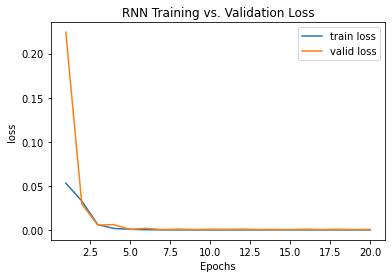

Loading best model: models/RNN\RNN_BEST_STOPPED_AT_4.pth


RNNModel(
  (rnn): RNN(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [3]:


# **Define relative file path for training data**
train_file = "..\\Data\\Train\\trains1990s.csv"

# **Load Training Data with Automatic Column Detection**
train_df = pd.read_csv(train_file)
print("Columns in dataset:", train_df.columns)  # Debugging: Show available columns

# **Find the correct date column**
possible_date_cols = ["Date", "date", "observation_date", "timestamp"]
for col in possible_date_cols:
    if col in train_df.columns:
        train_df[col] = pd.to_datetime(train_df[col])
        train_df.set_index(col, inplace=True)
        print(f"Using '{col}' as Date column.")
        break
else:
    raise ValueError("No valid date column found in dataset!")

# **Rename Value Column (Check if it exists)**
if "Value" in train_df.columns:
    train_df.rename(columns={"Value": "PCE"}, inplace=True)
elif "fred_PCEPI" in train_df.columns:
    train_df.rename(columns={"fred_PCEPI": "PCE"}, inplace=True)
else:
    raise ValueError("No valid column found for PCE data!")

# **Normalize Data**
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[["PCE"]])

# **Convert the scaled data to a 1D array**
train_series = train_scaled.flatten()

# **Function to Create Sequences**
def create_sequences(data, seq_length):
    """
    Creates sequences of length `seq_length` as inputs and the subsequent value as the target.
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i : i + seq_length])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)

# **Set Sequence Length**
sequence_length = 12
X, y = create_sequences(train_series, sequence_length)

# **Train-Validation Split (80% Train, 20% Validation)**
split_ratio = 0.8
split_idx = int(len(X) * split_ratio)

X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

# **Convert Data to PyTorch Tensors**
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)

# **Create DataLoaders**
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# **Train Model Using Modular Functions**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_model = RNNModel(input_size=1, hidden_size=64, num_layers=2).to(device)

# **Define Loss Function and Optimizer**
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# **Train the Model Using Modular Functions**
train_data = train_model(
    model=rnn_model,
    maxEpochs=50,
    modelSavePath=model_save_path,
    modelName="RNN",
    dataLoaderTrain=train_loader,
    dataLoaderValid=val_loader,
    lossFn=criterion,
    optimizer=optimizer,
    device=device,
    batchStatusUpdate=10,
    verbose=True
)

# **Plot Training vs. Validation Loss**
loss_curve(trainLoss=train_data["trainLoss"], validLoss=train_data["validLoss"], title="RNN Training vs. Validation Loss")

# **Find the best saved model dynamically**
best_model_files = glob.glob(os.path.join(model_save_path, "RNN_BEST_STOPPED_AT_*.pth"))
latest_model_path = os.path.join(model_save_path, "RNN_latest.pth")

if best_model_files:
    best_model_path = sorted(best_model_files)[-1]  # Pick the latest best-stopped model
    print(f"Loading best model: {best_model_path}")
elif os.path.exists(latest_model_path):
    best_model_path = latest_model_path
    print(f"No early-stopped model found. Loading latest model instead: {best_model_path}")
else:
    raise FileNotFoundError("No saved model found! Ensure training was completed successfully.")

# **Load the Best or Latest Model**
best_rnn_model = RNNModel(input_size=1, hidden_size=64, num_layers=2).to(device)
best_rnn_model.load_state_dict(torch.load(best_model_path))
best_rnn_model.eval()


        Date  Actual PCE  Predicted PCE
0 2015-01-01   96.653999      99.212814
1 2015-02-01   96.825005      99.094009
2 2015-03-01   97.007996      99.005455
3 2015-04-01   97.094002      98.977776
4 2015-05-01   97.326996      98.984703


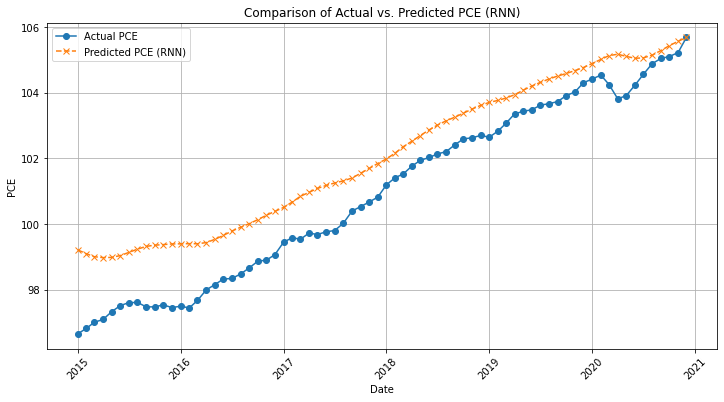

Root Mean Squared Error (RMSE) for RNN Model: 1.229453


In [4]:
# **Make Predictions on Validation Set**
best_rnn_model.eval()
rnn_predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        outputs = best_rnn_model(inputs)
        rnn_predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())

# **Concatenate batches into single arrays**
rnn_predictions = np.concatenate(rnn_predictions)
actuals = np.concatenate(actuals)

# **Inverse transform the normalized predictions and actual values back to the original scale**
rnn_predictions_inv = scaler.inverse_transform(rnn_predictions)
actuals_inv = scaler.inverse_transform(actuals)

# **Extract the dates corresponding to the validation predictions**
val_dates = train_df.index[split_idx + sequence_length:]

# **Create a DataFrame for comparison**
df_comparison = pd.DataFrame({
    "Date": val_dates,
    "Actual PCE": actuals_inv.flatten(),
    "Predicted PCE": rnn_predictions_inv.flatten()
})

# **Display the first few rows of the comparison DataFrame**
print(df_comparison.head())

# **Plot the Actual vs. Predicted PCE values**
plt.figure(figsize=(12, 6))
plt.plot(df_comparison["Date"], df_comparison["Actual PCE"], label="Actual PCE", marker="o", linestyle="-")
plt.plot(df_comparison["Date"], df_comparison["Predicted PCE"], label="Predicted PCE (RNN)", marker="x", linestyle="--")
plt.xlabel("Date")
plt.ylabel("PCE")
plt.title("Comparison of Actual vs. Predicted PCE (RNN)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# **Compute RMSE for Validation Predictions**
rmse_rnn = np.sqrt(mean_squared_error(actuals_inv, rnn_predictions_inv))
print(f"Root Mean Squared Error (RMSE) for RNN Model: {rmse_rnn:.6f}")
